## **Statistical Learning – Data science - 2021/22 – Exercise 4 – 26/04/2022**
# **Exercise 4: Analysis of Prostate Cancer dataset – shrinkage methods (regularization)**

In [1]:
# data analysis and wrangling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

from IPython.display import Image # to visualize images
from tabulate import tabulate # to create tables

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/prostate-data/tab4.png
/kaggle/input/prostate-data/tab4-no-cap.png
/kaggle/input/prostate-data/tab3.png
/kaggle/input/prostate-data/prostate.data
/kaggle/input/prostate-data/tab.png
/kaggle/input/prostate-data/tab2.png


## **1. Open your kernel SL_EX2_ProstateCancer_Surname in Kaggle**
> <h2>✅</h2>


## **2. Generate a copy called SL_EX4_Prostate_Shrinkage_Surname by the Fork button**
> <h2>✅</h2>


## **3. Import Ridge from sklearn.linear_model**
> <h2>✅</h2>

# **Data acquisition**

In [2]:
# Load the Prostate Cancer dataset
data = pd.read_csv('../input/prostate-data/prostate.data',sep='\t')

In [3]:
# Save "train" and lpsa" columns into Pandas Series variables
train = data['train']
lpsa = data['lpsa']

# Drop "train" and lpsa" variable from data
data = data.drop(columns=['Unnamed: 0','lpsa','train'],axis=1)

# **Data pre-processing**

In [4]:
## X VARIABLE:
# Split the data in train and test sets
dataTrain = data.loc[train == 'T'] # Obviously, len(idx)==len(dataTrain) is True!
dataTest = data.loc[train == 'F']

# Rename these two variables as "predictorsTrain" and "predictorsTest"
predictorsTrain = dataTrain
predictorsTest = dataTest


## Y VARIABLE:
# Split the "lpsa" in train and test sets
lpsaTrain = lpsa.loc[train == 'T']
lpsaTest = lpsa.loc[train == 'F']

## **Standardization**

In [5]:
# Standardize "predictorsTrain"
predictorsTrainMeans = predictorsTrain.mean()
predictorsTrainStds = predictorsTrain.std()
predictorsTrain_std = (predictorsTrain - predictorsTrainMeans)/predictorsTrainStds # standardized variables of predictorTrain

# Standardize "predictorsTest" (using the mean and std of predictorsTrain, it's better!)
predictorsTest_std = (predictorsTest - predictorsTrainMeans)/predictorsTrainStds # standardized variables of predictorTest

# Standardize all the data together (necessary for CV)
predictors = data
predictors_std = (predictors - predictors.mean())/predictors.std()

## **Split into Training and Test sets**

In [6]:
## TRAINING SET
X_train = predictorsTrain_std
Y_train = lpsaTrain

## TEST SET
X_test = predictorsTest_std
Y_test = lpsaTest

## All the data standardized
X = predictors_std
Y = lpsa

# **Ridge regression**

## **4. Starting from standardized data, generate a ridge regression model with $\alpha$=1.0 (called $\lambda$ in the slides)**

In [7]:
## Ridge Regression model trained on training set
ridge = Ridge(alpha=1, fit_intercept=True)
ridge.fit(X_train,Y_train); # if alpha=0, then Ridge coincides with OLS

## **5. Show model’s coefficients, intercept and score (on both the training and the test set)**

In [8]:
## For Ridge model

# Stats on train 
R2_train_ridge = ridge.score(X_train,Y_train)

# Stats on test
R2_test_ridge = ridge.score(X_test,Y_test)

round_coef = 3
print(f"\
About the the Ridge regression model for alpha = 1:\n\
* intercept: {ridge.intercept_.round(round_coef)}\n\
* model coefficients:: {ridge.coef_.round(round_coef).tolist()}\n\
* R^2 on training set: {R2_train_ridge.round(round_coef)}\n\
* R^2 on test set: {R2_test_ridge.round(round_coef)}\n\
")

About the the Ridge regression model for alpha = 1:
* intercept: 2.452
* model coefficients:: [0.69, 0.292, -0.135, 0.21, 0.304, -0.256, -0.011, 0.258]
* R^2 on training set: 0.694
* R^2 on test set: 0.512



## **6. Plot Ridge coefficients as functions of the regularization parameter alpha**

In [9]:
# create a vector of alphas
alphas = np.logspace(start = -1, stop = 4, num = 200, base = 10) # regularization params [base**start,base**end]

coefs_r = [] # lists to store model coeffs

for a in alphas:
    
    # Compute the Ridge model
    reg = Ridge(alpha=a, fit_intercept=True)
    reg.fit(X_train,Y_train)
    
    # Store coefficient
    coefs_r.append(reg.coef_)

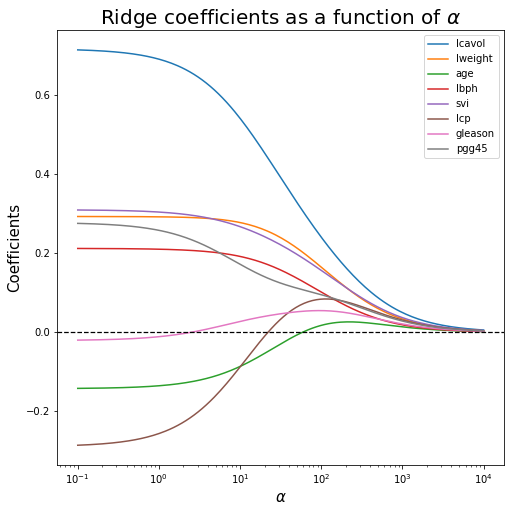

In [10]:
# fig 
width, height = 8, 8
fig, ax = plt.subplots(figsize=(width,height))

ax.plot(alphas, coefs_r)
ax.axhline(0, linestyle="--", linewidth=1.25, color="black")  # horizontal line

ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1]) # reverse the x-axis

ax.set_xlabel(r"$\alpha $", fontsize=15)
ax.set_ylabel("Coefficients", fontsize=15)
ax.set_title(r"Ridge coefficients as a function of $\alpha$", fontsize=20)
ax.legend(X_train.columns.tolist())

plt.show()

### **Ridge coefficients as functions of the effective DoF**

The effective degree of freedom of the Ridge regression is
$$\text{df} (\alpha ) = \sum_{i=1}^{n} \dfrac{d_i^2}{d_i^2+\alpha}$$
where $d_i$ are singular values of $X$.

In a linear-regression fit with p variables, the degrees-of-freedom of the fit is $df(\alpha)=p$, the number of free parameters.\
The idea is that although all p coefficients in a ridge fit will be non-zero, they are fit in a restricted fashion controlled by $\alpha$. Note that when we have no regularization $df(0)=p$ .

In [11]:
# Compute effective DoF

df_r = []
s2 = np.linalg.svd(X_train, compute_uv=False)**2   # singular values squared

for a in alphas:
    tmp = s2/(s2+a)
    df_r.append(tmp.sum())

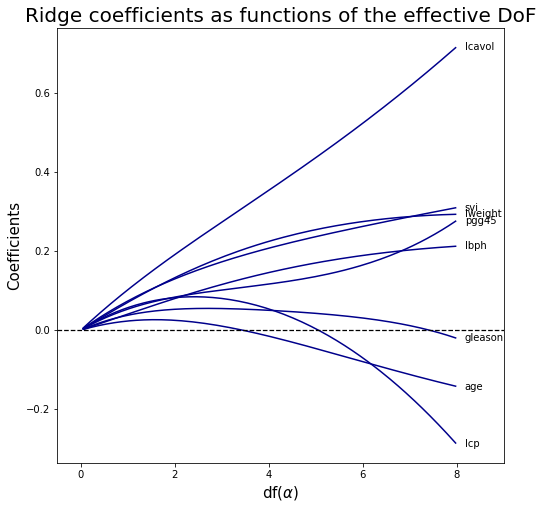

In [12]:
# fig 
width, height = 8, 8
palette = 'darkblue'
fig, ax = plt.subplots(figsize=(width,height))

ax.plot(df_r, coefs_r, color=palette)
#ax.axvline(5, linestyle=":", linewidth=1.25, color="red")     # vertical line
ax.axhline(0, linestyle="--", linewidth=1.25, color="black")  # horizontal line

ax.set_xlabel(r"df($\alpha $)", fontsize=15)
ax.set_ylabel("Coefficients", fontsize=15)
ax.set_title("Ridge coefficients as functions of the effective DoF", fontsize=20)
ax.set_xlim(-0.5, 9)

# Annotate the name of each variable at the last value
coords = zip([8]*len(coefs_r[0]),coefs_r[0]) # last value where I want to annotate the corresponding label
labels = X_train.columns.tolist()

for coord,lab in zip(coords,labels):
    ax.annotate(xy=coord,                    # The point (x, y) to annotate.
                xytext=coord,                # The position (x, y) to place the text at.
                textcoords='offset points',
                text=lab,
                verticalalignment='center')

plt.show()

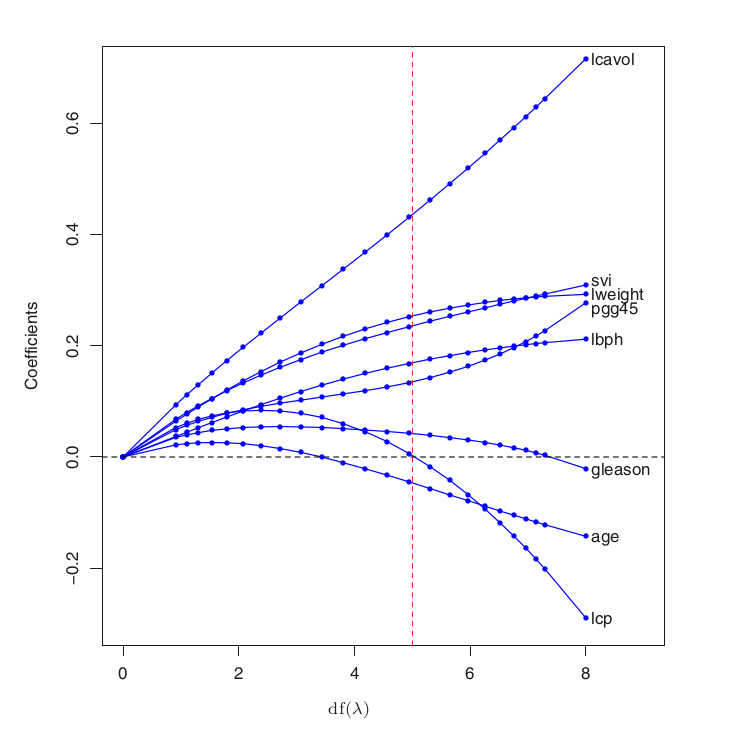

In [13]:
# We can compare the above chart with the one in the book (figure 3.8):
scale = 70
Image("../input/prostate-data/tab4-no-cap.png", width = width*scale, height = height*scale)

# **Ridge regression with LOOCV Cross Validation**

## **7. Find the best regularization parameter by cross-validation using leave-one-out**
Use only the training set **(97 observations)**.\
Use **store_cv_values=True** to get the leave-one-out errors.\
The **cv_values_** in the result object provided by **RidgeCV** contains ***one row for each observation (97 rows) and one column for each alpha in alphas (100 columns)***.\
Cell i,j contains the leave-one-out mean squared error on the i-th observation given the j-th alpha.\
By computing the mean by column of cv_values_ you obtain the average cross-validation error for each alpha. This is the value that has to be minimized (see next step).

In [14]:
# Create and train the model using all the data
alphas = np.logspace(start=-1,stop=4,num=200,base=10.0)

# cv = None, to use the Leave-One-Out cross-validation
ridgeLOO = RidgeCV(alphas = alphas, cv=None, fit_intercept = True, store_cv_values = True)
ridgeLOO.fit(X,Y)

cvVal = ridgeLOO.cv_values_  # cvVal[i,j] = LOO MSE on the i-th observation given the j-th alpha
cvMeans = np.mean(cvVal,axis=0)
cvStd = np.std(cvVal,axis=0)

print("The shape is: ",np.shape(cvVal)) # contains one row for each observation and one column for each alpha in alphas

The shape is:  (97, 200)


In [15]:
## Best regularization parameter: identify the minimum LOOCV MSE and the related alpha

min_val = min(cvMeans)
# min_val = abs(ridgeLOO.best_score_)   # alternative way
min_alpha = ridgeLOO.alpha_
# min_alpha = ridgeLOO.alphas[np.argmin(cvMeans)]   # alternative way

print(f"\
The best regularization parameter is \u03B1={min_alpha.round(3)}, with corresponding LOOCV MSE equal to {min_val.round(3)}.\
")

The best regularization parameter is α=6.08, with corresponding LOOCV MSE equal to 0.536.


## **9. Identify the minimum leave-one-out cross-validation error and the related alpha, model coefficients and performance**

In [16]:
## Perform the Ridge regression on the best alpha
ridgeLOO_best = RidgeCV(alphas = min_alpha, fit_intercept = True)
ridgeLOO_best.fit(X,Y)

# Stats on train 
R2_train_ridgeLOO_best = ridgeLOO_best.score(X_train,Y_train)

# Stats on test
R2_test_ridgeLOO_best = ridgeLOO_best.score(X_test,Y_test)

# print some info about Ridge CV
round_coef = 3

print(f"\
For this value of \u03B1={min_alpha.round(round_coef)} we have the following parameters:\n\
* intercept: {ridgeLOO_best.intercept_.round(round_coef)}\n\
* model coefficients: {ridgeLOO_best.coef_.round(round_coef).tolist()}\n\
* R^2 on training set: {R2_train_ridgeLOO_best.round(round_coef)}\n\
* R^2 on test set: {R2_test_ridgeLOO_best.round(round_coef)}\n\
")

For this value of α=6.08 we have the following parameters:
* intercept: 2.478
* model coefficients: [0.59, 0.26, -0.128, 0.126, 0.287, -0.065, 0.045, 0.099]
* R^2 on training set: 0.67
* R^2 on test set: 0.609



## **8. Plot the leave-one-out cross-validation curve**
- Hint: plot the alphas vector against the average cross-validation error for each alpha computed at the last point

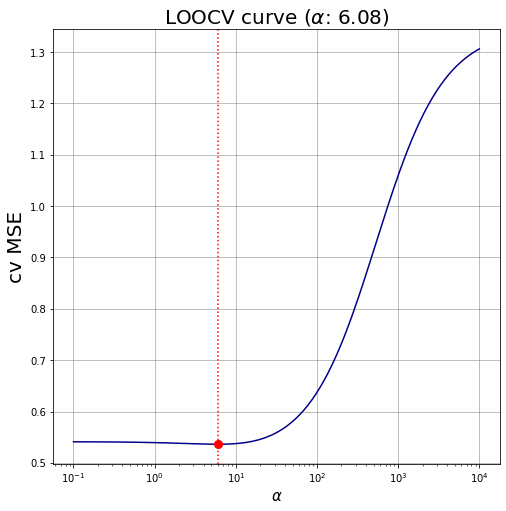

In [17]:
# fig 
width, height = 8, 8
palette = 'darkblue'
fig, ax = plt.subplots(figsize=(width,height))

# straight lines
ax.plot(ridgeLOO.alphas, cvMeans, color='darkblue')

ax.plot(min_alpha, min_val, marker= 'o', markersize = 8, color='r')
ax.axvline(min_alpha, linestyle=":", linewidth=1.5, color="red") # vertical line

ax.set_xlabel(r"$\alpha$", fontsize=15)
ax.set_ylabel("cv MSE", fontsize=20)
ax.set_title(fr"LOOCV curve ($\alpha$: {ridgeLOO.alpha_.round(3)})", fontsize=20)
ax.set_xscale('log')
ax.grid(color='grey', linestyle='-', linewidth=0.5);
# ax.set_xlim(ax.get_xlim()[::-1]) # reverse the x-axis

plt.show()

# **Ridge regression with 10-Folds Cross Validation**

## **10. Identify the minimum 10-folds cross-validation error and the related alpha, model coefficients and performance**

In [18]:
# store_cv_values = False otherwise it is incompatible with cv!=none
ridge_10cv = RidgeCV(alphas = alphas, fit_intercept = True, store_cv_values = False, cv = 10);
ridge_10cv.fit(X,Y);

In [19]:
# Best regularization parameter: identify the minimum LOO CV error and the related alpha
min_alpha_10cv = ridge_10cv.alpha_
min_val_10cv = abs(ridge_10cv.best_score_) # loocv of 10cv

print(f"\
The best regularization parameters is \u03B1={min_alpha_10cv.round(3)}, with corresponding Leave-One-Out MSE equal to: {min_val_10cv.round(3)}\n\
")

The best regularization parameters is α=207.292, with corresponding Leave-One-Out MSE equal to: 52.447



In [20]:
## Perform the Ridge regression with 10 folds on the best alpha (in order to perform on train and test sets)
ridge_10cv_best = RidgeCV(alphas = min_alpha_10cv, fit_intercept = True)
ridge_10cv_best.fit(X,Y)

# Stats on train 
R2_train_ridge_10cv_best = ridge_10cv_best.score(X_train,Y_train)

# Stats on test
R2_test_ridge_10cv_best = ridge_10cv_best.score(X_test,Y_test)

# print some info about Ridge CV
round_coef = 3

print(f"\
For this value of \u03B1={min_alpha_10cv.round(round_coef)} we have the following parameters:\n\
* intercept: {ridge_10cv_best.intercept_.round(round_coef)}\n\
* model coefficients: {ridge_10cv_best.coef_.round(round_coef).tolist()}\n\
* R^2 on training set: {R2_train_ridge_10cv_best.round(round_coef)}\n\
* R^2 on test set: {R2_test_ridge_10cv_best.round(round_coef)}\n\
")

For this value of α=207.292 we have the following parameters:
* intercept: 2.478
* model coefficients: [0.195, 0.118, 0.01, 0.047, 0.131, 0.101, 0.058, 0.068]
* R^2 on training set: 0.468
* R^2 on test set: 0.459



# **Comparison between Ridge LOOCV CV and Ridge 10Folds CV**

In [21]:
# table
round_coef = 3
headers = ['Term','Ridge LOOCV', 'Ridge 10-CV']

# labels (0-th column)
intercept_label = np.array(['Intercept'])
alpha_label = np.array(['Best Alpha'])
coefs_label = X_train.columns.tolist()
labels = np.concatenate((intercept_label,alpha_label,coefs_label),axis=0)

# ridge LOOCV column values
model = ridgeLOO_best
model_intercept_val = np.array([model.intercept_])
model_alpha_val = np.array([model.alpha_])
model_coefs_val = model.coef_
ridgeLOO_values = np.concatenate((model_intercept_val,model_alpha_val,model_coefs_val), axis=0).round(round_coef)

# ridge 10CV column values
model = ridge_10cv_best
model_intercept_val = np.array([model.intercept_])
model_alpha_val = np.array([model.alpha_])
model_coefs_val = model.coef_
ridge_10cv_values = np.concatenate((model_intercept_val,model_alpha_val,model_coefs_val), axis=0).round(round_coef)

table = np.column_stack((labels, ridgeLOO_values, ridge_10cv_values))

print(tabulate(table, headers=headers, tablefmt='fancy_grid'))

╒════════════╤═══════════════╤═══════════════╕
│ Term       │   Ridge LOOCV │   Ridge 10-CV │
╞════════════╪═══════════════╪═══════════════╡
│ Intercept  │         2.478 │         2.478 │
├────────────┼───────────────┼───────────────┤
│ Best Alpha │         6.08  │       207.292 │
├────────────┼───────────────┼───────────────┤
│ lcavol     │         0.59  │         0.195 │
├────────────┼───────────────┼───────────────┤
│ lweight    │         0.26  │         0.118 │
├────────────┼───────────────┼───────────────┤
│ age        │        -0.128 │         0.01  │
├────────────┼───────────────┼───────────────┤
│ lbph       │         0.126 │         0.047 │
├────────────┼───────────────┼───────────────┤
│ svi        │         0.287 │         0.131 │
├────────────┼───────────────┼───────────────┤
│ lcp        │        -0.065 │         0.101 │
├────────────┼───────────────┼───────────────┤
│ gleason    │         0.045 │         0.058 │
├────────────┼───────────────┼───────────────┤
│ pgg45      

# **Lasso regression**

## **11. Import Lasso from sklearn.linear_model**
> <h2>✅</h2>
## **12. Generate a lasso regression model with a specific regularization parameter alpha=0.1**

In [22]:
# Create a Lasso regression model
lasso = Lasso(alpha = 0.1)
lasso.fit(X_train,Y_train);

## **14 Show model’s coefficients, intercept and score (on both the training and the test set)**

In [23]:
# Stats on train 
R2_train_lasso = lasso.score(X_train,Y_train)

# Stats on test
R2_test_lasso = lasso.score(X_test,Y_test)

round_coef = 3

print(f"\
About the the Lasso regression model:\n\
* intercept: {lasso.intercept_.round(round_coef)}\n\
* model coefficients: {lasso.coef_.round(round_coef).tolist()}\n\
* R^2 on training set: {R2_train_lasso.round(round_coef)}\n\
* R^2 on test set: {R2_test_lasso.round(round_coef)}\n\
")

About the the Lasso regression model:
* intercept: 2.452
* model coefficients: [0.575, 0.23, -0.0, 0.105, 0.172, 0.0, 0.0, 0.065]
* R^2 on training set: 0.648
* R^2 on test set: 0.569



## **15. Plot Lasso coefficients as a function of the regularization parameter**

In [24]:
# Lasso path: coefficients as functions of the regularization parameters

# we can set either alphas or eps: the smaller eps, the longer the path is
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, Y_train, eps = 5e-3)

In [25]:
# For each coefficient I compute the first index in which it becomes zero.
nz_list = list((coefs_lasso !=0).argmax(axis=1)-1)

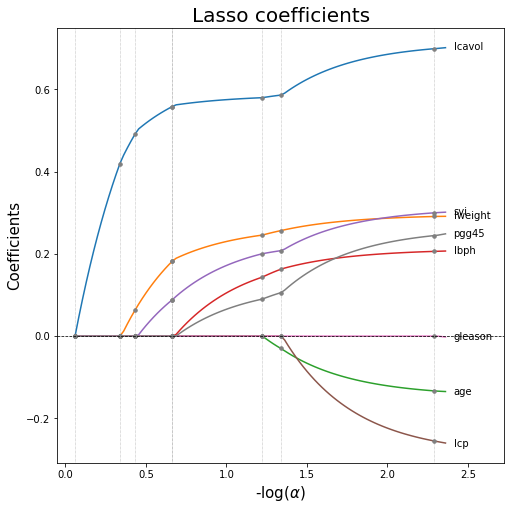

In [26]:
# fig 
width, height = 8, 8
fig, ax = plt.subplots(figsize=(width,height))

xx = -np.log10(alphas_lasso) # neg_log_alphas_lasso

for coef in coefs_lasso:
    ax.plot(xx, coef)

# Info about when coefs are shrunken to 0
for nz in nz_list:
    ax.axvline(xx[nz], linestyle=":", linewidth=0.5, color="grey") # vertical line
    
    # dots where coefs become zero
    for coef in coefs_lasso:
        ax.plot(xx[nz], coef[nz],  linestyle='None', marker = 'o', markersize=3.5, color = 'grey')
           
ax.axhline(y=0, linestyle='--',linewidth=0.75, color='black') # horizontal line
#ax.grid(color='grey', linestyle='-', linewidth=0.5);
ax.set_xlabel(r"-log($\alpha$)", fontsize=15)
ax.set_ylabel("Coefficients", fontsize=15)
ax.set_title("Lasso coefficients", fontsize=20)


## Annotate the name of each variable at the last value

ax.set_xlim(-0.05, ax.get_xlim()[1]*1.1)      # enlarge xaxis
alpha_end = xx[-1]*1.015                      # last value of alpha
last_val = [last for *_, last in coefs_lasso] # last value of all the 8 coeffs

coords = zip([alpha_end]*8,last_val)
labels = X_train.columns.tolist()

for coord,lab in zip(coords,labels):
    ax.annotate(xy=coord,            # The point (x, y) to annotate.
                xytext=coord,        # The position (x, y) to place the text at.
                textcoords='offset points',
                text=lab,
                verticalalignment='center')

plt.show()

## **16. Find the best regularization parameter by cross-validation**
* Hint: use function LassoCV from sklearn
* Test different number of cv folds

## **17. Plot the mean square error curve for each fold and for the average of all the folds**

In [27]:
## Some params
cvFolds = np.arange(start = 5, stop = 25, step  = 5)
alpha_lasso_cv = np.logspace(-4,1,100,10)

# where we store some info
best_alpha, performances_lasso_cv = [], []
intercepts_lasso_cv, model_coefs = [], []

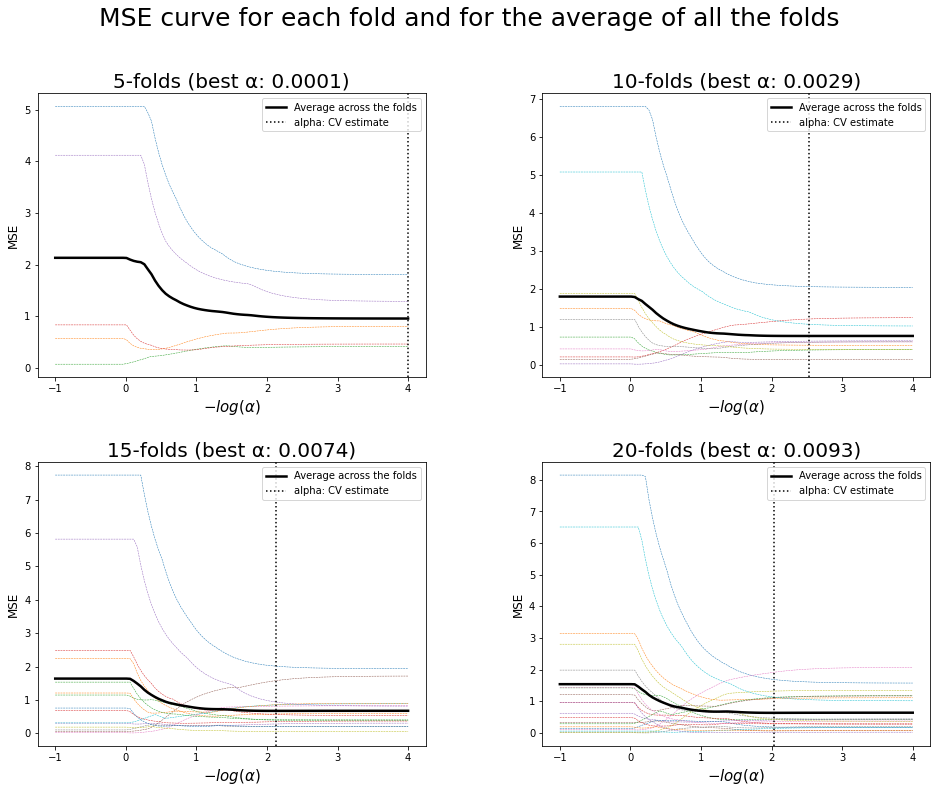

In [28]:
# Initialize the fig
nrow, ncol = 2, 2
width, height = 16, 12 # single subplot
fig, axes = plt.subplots(nrow,ncol,figsize=(width,height))

for folds, ax in zip(cvFolds,axes.flatten()):

    lasso_cv = LassoCV(cv=folds, alphas=alpha_lasso_cv)
    lasso_cv.fit(X_train,Y_train) # fitting the model using n-folds
    
    # R^2 train
    pred_train_lasso_cv = lasso_cv.predict(X_train)
    Rsquared_train_lasso_cv = lasso_cv.score(X_train,Y_train)
    # R^2 test
    pred_test_lasso_cv = lasso_cv.predict(X_test)
    Rsquared_test_lasso_cv = lasso_cv.score(X_test,Y_test)
    
    #store some info
    best_alpha.append(lasso_cv.alpha_)
    model_coefs.append(lasso_cv.coef_)
    intercepts_lasso_cv.append(lasso_cv.intercept_)
    performances_lasso_cv.append([Rsquared_train_lasso_cv,Rsquared_test_lasso_cv])
    
    m_log_alphas = -np.log10(lasso_cv.alphas_)
    ax.plot(m_log_alphas, lasso_cv.mse_path_, linestyle="--", linewidth=0.5)
    ax.plot(m_log_alphas, lasso_cv.mse_path_.mean(axis=1), color="black", label="Average across the folds", linewidth=2.5)

    ax.axvline(-np.log10(lasso_cv.alpha_), linestyle=":", color="black", label="alpha: CV estimate") # best alpha

    #ax.grid(color='grey', linestyle='-', linewidth=0.5);
    ax.set_xlabel(r"$-log(\alpha)$", fontsize=15)
    ax.set_ylabel("MSE", fontsize=12)
    ax.set_title(f"{folds}-folds (best \u03B1: {lasso_cv.alpha_.round(4)})", fontsize=20)
    ax.legend(loc='upper right')

    
plt.axis("tight")

# set the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle("MSE curve for each fold and for the average of all the folds",fontsize=25)
plt.show()

In [29]:
# Best regularization parameter by cross-validation
print("Best regularization parameter \u03B1:")
for nfolds, alpha in zip(cvFolds,best_alpha):
    print(f" * For {nfolds}-folds: {alpha.round(4)}")

Best regularization parameter α:
 * For 5-folds: 0.0001
 * For 10-folds: 0.0029
 * For 15-folds: 0.0074
 * For 20-folds: 0.0093


## **18. Show the best alpha, model coefficients and performance on training and test set**

In [30]:
## For Lasso_cv model

round_coef = 3
print("Some stats about the performance of Lasso CV with different folds:\n")
for k in range(0,len(cvFolds)):
    print(f"* For {cvFolds[k]}-folds:\n\
    - best \u03B1: {best_alpha[k].round(round_coef)}\n\
    - intercept: {intercepts_lasso_cv[k].round(round_coef)}\n\
    - coefficients: {model_coefs[k].round(round_coef).tolist()}\n\
    - score on training set: {performances_lasso_cv[k][0].round(round_coef)}\n\
    - score on test set: {performances_lasso_cv[k][1].round(round_coef)}\n\
    ")

Some stats about the performance of Lasso CV with different folds:

* For 5-folds:
    - best α: 0.0
    - intercept: 2.452
    - coefficients: [0.716, 0.293, -0.142, 0.212, 0.309, -0.288, -0.02, 0.277]
    - score on training set: 0.694
    - score on test set: 0.504
    
* For 10-folds:
    - best α: 0.003
    - intercept: 2.452
    - coefficients: [0.706, 0.292, -0.137, 0.209, 0.304, -0.27, -0.008, 0.258]
    - score on training set: 0.694
    - score on test set: 0.511
    
* For 15-folds:
    - best α: 0.007
    - intercept: 2.452
    - coefficients: [0.692, 0.289, -0.127, 0.204, 0.295, -0.241, -0.0, 0.237]
    - score on training set: 0.694
    - score on test set: 0.521
    
* For 20-folds:
    - best α: 0.009
    - intercept: 2.452
    - coefficients: [0.687, 0.287, -0.123, 0.202, 0.29, -0.228, -0.0, 0.23]
    - score on training set: 0.693
    - score on test set: 0.524
    


### **Comparison between Lasso with different cv folds**

In [31]:
# table
round_coef = 3
headers = ['Term','Lasso CV\n(5-folds)', 'Lasso CV\n(10-folds)', 'Lasso CV\n(15-folds)', 'Lasso CV\n(20-folds)']

lasso_cv_values = []

# labels (0-th column)
intercept_label = np.array(['Intercept'])
alpha_label = np.array(['Best Alpha'])
coefs_label = X_train.columns.tolist()
labels = np.concatenate((intercept_label,alpha_label,coefs_label),axis=0)


for idx in range(0,4):
    model_intercept_val = np.array([intercepts_lasso_cv[idx]])
    model_alpha_val = np.array([best_alpha[idx]])
    model_coefs_val = model_coefs[idx]
    
    tmp = np.concatenate((model_intercept_val,model_alpha_val,model_coefs_val), axis=0).round(round_coef)
    
    lasso_cv_values.append(tmp)

# table = np.column_stack((labels,lasso_cv_values))
table = np.column_stack((labels, lasso_cv_values[0], lasso_cv_values[1], lasso_cv_values[2], lasso_cv_values[3]))


print(tabulate(table, headers=headers, tablefmt='fancy_grid'))

╒════════════╤═════════════╤══════════════╤══════════════╤══════════════╕
│ Term       │    Lasso CV │     Lasso CV │     Lasso CV │     Lasso CV │
│            │   (5-folds) │   (10-folds) │   (15-folds) │   (20-folds) │
╞════════════╪═════════════╪══════════════╪══════════════╪══════════════╡
│ Intercept  │       2.452 │        2.452 │        2.452 │        2.452 │
├────────────┼─────────────┼──────────────┼──────────────┼──────────────┤
│ Best Alpha │       0     │        0.003 │        0.007 │        0.009 │
├────────────┼─────────────┼──────────────┼──────────────┼──────────────┤
│ lcavol     │       0.716 │        0.706 │        0.692 │        0.687 │
├────────────┼─────────────┼──────────────┼──────────────┼──────────────┤
│ lweight    │       0.293 │        0.292 │        0.289 │        0.287 │
├────────────┼─────────────┼──────────────┼──────────────┼──────────────┤
│ age        │      -0.142 │       -0.137 │       -0.127 │       -0.123 │
├────────────┼─────────────┼──────────

# **Results and comparisons** 

## **OLS**

In [32]:
## For OLS model

## Create an OLS model fitted on training set
ols = LinearRegression(fit_intercept=True);
ols.fit(X_train,Y_train);

# Stats on train 
R2_train_ols = ols.score(X_train,Y_train)

# Stats on test
R2_test_ols = ols.score(X_test,Y_test)

round_coef = 3
print(f"About the the OLS regression model:\n\
* coefficients: {ols.coef_.round(round_coef).tolist()}\n\
* intercept: {ols.intercept_.round(round_coef).round(round_coef)}\n\
* R^2 on training set: {R2_train_ols.round(round_coef)}\n\
* R^2 on test set: {R2_test_ols.round(round_coef)}\n\
")

About the the OLS regression model:
* coefficients: [0.716, 0.293, -0.143, 0.212, 0.31, -0.289, -0.021, 0.277]
* intercept: 2.452
* R^2 on training set: 0.694
* R^2 on test set: 0.503



## **Best Subset Selection**

In [33]:
## For Best Subset model - RSS - Andrea

predLabels = ['lcavol','svi','gleason']
X1, y1 = X_train[predLabels], Y_train
X2, y2 = X_test[predLabels], Y_test

# Create the linear model, fitting also the intecept (non-zero)
bssA = LinearRegression(fit_intercept = True).fit(X1,y1)

# Stats on train 
R2_train_bssA = bssA.score(X1,y1)

# Stats on test
R2_test_bssA = bssA.score(X2,y2)

round_coef = 3
print(f"About the the Linear Regression regression model (choosing the predictors selected by BSS - performed by Andrea):\n\
* predictors: {predLabels}\n\
* coefficients: {bssA.coef_.round(round_coef).tolist()}\n\
* intercept: {bssA.intercept_.round(round_coef).round(round_coef)}\n\
* R^2 on training set: {R2_train_bssA.round(round_coef)}\n\
* R^2 on test set: {R2_test_bssA.round(round_coef)}\n\
")

About the the Linear Regression regression model (choosing the predictors selected by BSS - performed by Andrea):
* predictors: ['lcavol', 'svi', 'gleason']
* coefficients: [0.74, 0.225, 0.029]
* intercept: 2.452
* R^2 on training set: 0.561
* R^2 on test set: 0.635



<div class="alert alert-warning" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"></i>
        </div>
        <div class="col-xs-11">
                <strong>Warning: Choosing the bestBest RSS for Best Selection, Backward Selection and Forward Selection gave the same choice of predictors: [lcavol, svi, gleason]
            </strong>
        </div>   
    </div> 
</div>

In [34]:
## For Best Subset model - RSS - Hastie and Tibshirani (book)

predLabels = ['lcavol','lweight']
X1, y1 = X_train[predLabels], Y_train
X2, y2 = X_test[predLabels], Y_test

# Create the linear model, fitting also the intecept (non-zero)
bssHT = LinearRegression(fit_intercept = True).fit(X1,y1)

# Stats on train 
R2_train_bssHT = bssHT.score(X1,y1)

# Stats on test
R2_test_bssHT = bssHT.score(X2,y2)

round_coef = 3
print(f"About the the Linear Regression regression model (choosing the predictors selected by BSS - performed by HT):\n\
* predictors: {predLabels}\n\
* coefficients: {bssHT.coef_.round(round_coef).tolist()}\n\
* intercept: {bssHT.intercept_.round(round_coef).round(round_coef)}\n\
* R^2 on training set: {R2_train_bssHT.round(round_coef)}\n\
* R^2 on test set: {R2_test_bssHT.round(round_coef)}\n\
")

About the the Linear Regression regression model (choosing the predictors selected by BSS - performed by HT):
* predictors: ['lcavol', 'lweight']
* coefficients: [0.78, 0.352]
* intercept: 2.452
* R^2 on training set: 0.615
* R^2 on test set: 0.531



<div class="alert alert-warning" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"></i>
        </div>
        <div class="col-xs-11">
                <strong>Warning: BSS performed by HT [book]
            </strong>
        </div>   
    </div> 
</div>

In [35]:
ols.coef_

array([ 0.71640701,  0.2926424 , -0.14254963,  0.2120076 ,  0.30961953,
       -0.28900562, -0.02091352,  0.27734595])

In [36]:
# table
round_coef = 3
headers = ['Term','OLS','BSS\n(Andrea)','BSS\n(HT)','Ridge CV\n(LOOCV)','Ridge CV\n(10 Folds)', 'Lasso\n(alpha=0.1)']

# labels (0-th column)
intercept_label = np.array(['Intercept'])
coefs_label = X_train.columns.tolist()
te_label = np.array(['Test Error\n(R^2 on test set)'])
labels = np.concatenate((intercept_label,coefs_label,te_label),axis=0)

# ols columns values
ols_int = np.array([ols.intercept_])
ols_coefs = ols.coef_
ols_te = np.array([R2_test_ols])
ols_values = np.concatenate((ols_int,ols_coefs,ols_te), axis=0).round(round_coef)

# BSS Andrea columns values
bssA_int = np.array([bssA.intercept_])
tmp = [bssA.coef_[0],0,0,0,bssA.coef_[1],0,bssA.coef_[2],0]
bssA_coefs = np.array(tmp)
bssA_te = np.array([R2_test_bssA])
bssA_values = np.concatenate((bssA_int, bssA_coefs, bssA_te), axis=0).round(round_coef)

# BSS Hastie and Tibshirani [book] columns values
bssHT_int = np.array([bssHT.intercept_])
tmp = [bssHT.coef_[0],bssHT.coef_[1],0,0,0,0,0,0]
bssHT_coefs = np.array(tmp)
bssHT_te = np.array([R2_test_bssHT])
bssHT_values = np.concatenate((bssHT_int, bssHT_coefs, bssHT_te), axis=0).round(round_coef)

# ridge LOO columns values
model = ridgeLOO_best
model_int = np.array([model.intercept_])
model_coefs = model.coef_
model_te = np.array([R2_test_ridgeLOO_best])
ridge_cv_values = np.concatenate((model_int,model_coefs, model_te), axis=0).round(round_coef)

# ridge 10 CV columns values
model = ridge_10cv_best
model_int = np.array([model.intercept_])
model_coefs = model.coef_
model_te = np.array([R2_test_ridge_10cv_best])
ridge_10cv_values = np.concatenate((model_int,model_coefs, model_te), axis=0).round(round_coef)

# lasso columns values
lasso_int = np.array([lasso.intercept_])
lasso_coefs = lasso.coef_
lasso_te = np.array([R2_test_lasso])
lasso_values = np.concatenate((lasso_int,lasso_coefs, lasso_te), axis=0).round(round_coef)

table = np.column_stack((labels,ols_values,bssA_values,bssHT_values,ridge_cv_values,ridge_10cv_values, lasso_values))

print(tabulate(table, headers=headers, tablefmt='fancy_grid'))

╒═══════════════════╤════════╤════════════╤════════╤════════════╤══════════════╤═══════════════╕
│ Term              │    OLS │        BSS │    BSS │   Ridge CV │     Ridge CV │         Lasso │
│                   │        │   (Andrea) │   (HT) │    (LOOCV) │   (10 Folds) │   (alpha=0.1) │
╞═══════════════════╪════════╪════════════╪════════╪════════════╪══════════════╪═══════════════╡
│ Intercept         │  2.452 │      2.452 │  2.452 │      2.478 │        2.478 │         2.452 │
├───────────────────┼────────┼────────────┼────────┼────────────┼──────────────┼───────────────┤
│ lcavol            │  0.716 │      0.74  │  0.78  │      0.59  │        0.195 │         0.575 │
├───────────────────┼────────┼────────────┼────────┼────────────┼──────────────┼───────────────┤
│ lweight           │  0.293 │      0     │  0.352 │      0.26  │        0.118 │         0.23  │
├───────────────────┼────────┼────────────┼────────┼────────────┼──────────────┼───────────────┤
│ age               │ -0.143 │

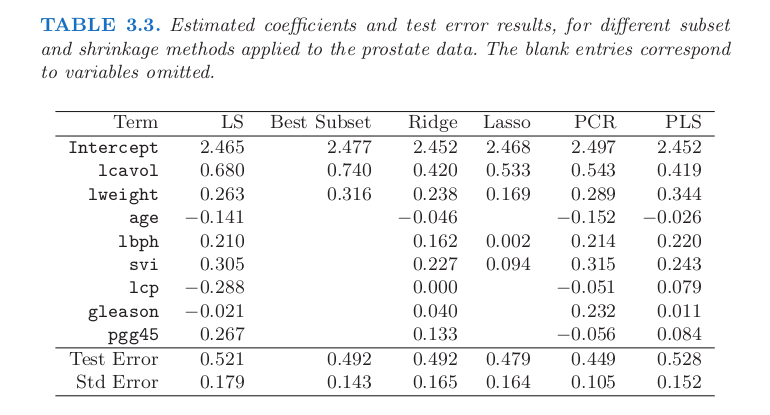

In [37]:
# We can compare the above taqble with the one in the book:
Image("../input/prostate-data/tab3.png")

<div class="alert alert-warning" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"></i>
        </div>
        <div class="col-xs-11">
                <strong>Warning: In the book is not provided the reg parameter choosen to perform Lasso for the table
            </strong>
        </div>   
    </div> 
</div>